In [92]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [93]:
import os

In [94]:
import torch.nn as nn
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [95]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            # 이미지 파일 읽기
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # 이미지 크기 조정 (300x300)
                img = cv2.resize(img, (300, 300))
                images.append(img)
                
                # 파일 이름에 따라 라벨 설정
                if 'O' in filename or 'o' in filename:
                    labels.append(0)
                elif 'X' in filename or 'x' in filename:
                    labels.append(1)
                else:
                    print(f"Warning: {filename} does not contain 'O' or 'X'")
    # 넘파이 배열로 변환 후 텐서로 변환
    images = np.array(images)
    labels = np.array(labels)
    
    # 이미지 배열 차원 조정 (N, 1, 300, 300)
    images = images[:, np.newaxis, :, :]
    
    return images, labels

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
from sklearn.model_selection import KFold

In [98]:
kfold = KFold(n_splits=5)

# ------------여기부터 CNN---------------------

In [106]:
def oneHot(data):
    y = pd.get_dummies(data)
    y.rename(columns={0: 'O'}, inplace=True)
    y.rename(columns={1: 'X'}, inplace=True)
    y = np.array(y)
    data = torch.tensor(y, dtype=torch.long)
    return data

In [115]:
data_folder = './datasets'

X_data, y_data = load_images_from_folder(data_folder)
y_data = oneHot(y_data)
X_data = torch.tensor(np.array(X_data)/255, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=20)
test_loader = DataLoader(test_dataset, batch_size=20)

In [116]:
y_data

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        

In [46]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 1*300*300 -> 32*150*150
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 32*150*150 -> 64*75*75
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(64*75*75, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

In [47]:
def train(epoch):
    model.train()
    running_loss = 0.0
    for data, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{training_epochs}], Loss: {running_loss/len(train_loader)}')

In [48]:
learning_rate = 0.01
training_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
# 모델 생성
model = CNN()

for epoch in range(training_epochs):
    train(epoch)

Epoch [1/5], Loss: 0.6914499302705129
Epoch [2/5], Loss: 0.6914499302705129
Epoch [3/5], Loss: 0.6914499302705129
Epoch [4/5], Loss: 0.6914499302705129
Epoch [5/5], Loss: 0.6914499302705129


In [44]:
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()  # 모델을 평가 모드로 설정
    
    # 이미지와 예측된 레이블을 저장할 리스트 초기화
    images = []
    predicted_labels = []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_onehot = torch.zeros_like(outputs)
            predicted_onehot.scatter_(1, predicted.unsqueeze(1), 1)
            
            for j in range(inputs.size(0)):
                images.append(inputs[j])  # 이미지를 CPU로 이동하여 리스트에 추가
                predicted_labels.append(predicted_onehot[j])  # 예측된 레이블을 CPU로 이동하여 리스트에 추가
                
                if len(images) >= num_images:
                    break
            
            if len(images) >= num_images:
                break
    
    # 이미지와 예측된 레이블 시각화
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    fig.suptitle('Predicted Labels')
    
    for i in range(num_images):
        image = images[i].permute(1, 2, 0)  # 이미지 차원 순서 변경 (C, H, W) -> (H, W, C)
        predicted_label = predicted_labels[i].numpy()  # 텐서를 넘파이 배열로 변환
        
        axes[0, i].imshow(image)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')
        
        axes[1, i].bar(range(len(predicted_label)), predicted_label)
        axes[1, i].set_xticks(range(len(predicted_label)))
        axes[1, i].set_title('Predicted Label')
    
    plt.tight_layout()
    plt.show()

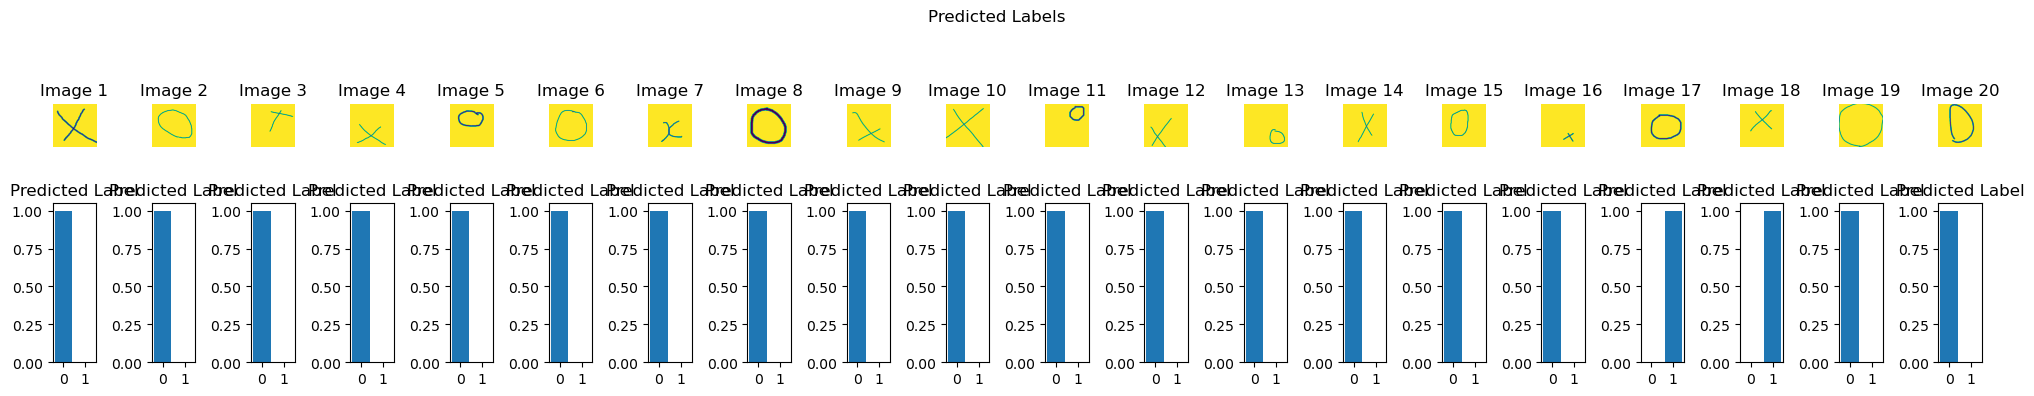

In [45]:
visualize_predictions(model, test_loader, num_images=20)

In [101]:
# 모델 시각화 함수
def visualize_predictions(model, dataloader, num_images=40):
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(5, 8, figsize=(40, 12))
    
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            for j in range(data.size(0)):
                if images_so_far == num_images:
                    break
                
                row = images_so_far // 8
                col = images_so_far % 8
                
                img = data[j].cpu().numpy().transpose((1, 2, 0)).squeeze()
                true_label = 'O' if targets[j].item() == 0 else 'X'
                pred_label = 'O' if predicted[j].item() == 0 else 'X'
                axes[row, col].imshow(img, cmap='gray')
                axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}')
                axes[row, col].axis('off')
                
                images_so_far += 1
                
                if images_so_far == num_images:
                    break
            if images_so_far == num_images:
                break
    plt.tight_layout()
    plt.show()

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

X_data, y_data = load_images_from_folder(data_folder)
y_data = np.argmax(oneHot(y_data), axis=1)  # 클래스 인덱스 형태로 변환
X_data = torch.tensor(np.array(X_data) / 255, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(64 * 75 * 75, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# 모델, 손실 함수, 옵티마이저 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 함수
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += targets.size(0)
            total_correct += (predicted == targets).sum().item()
        
        avg_loss = total_loss / len(train_loader)
        accuracy = (total_correct / total_samples) * 100
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 모델 평가 함수
def evaluate_model(model, criterion, test_loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += targets.size(0)
            total_correct += (predicted == targets).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = (total_correct / total_samples) * 100
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# 모델 학습
train_model(model, criterion, optimizer, train_loader, num_epochs=10)

# 모델 평가
evaluate_model(model, criterion, test_loader)

C:\Users\tkdql\AppData\Local\Temp\ipykernel_18460\3228615598.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.long)


Epoch [1/10], Loss: 26.9095, Accuracy: 53.57%
Epoch [2/10], Loss: 0.3204, Accuracy: 83.93%
Epoch [3/10], Loss: 0.0996, Accuracy: 95.09%
Epoch [4/10], Loss: 0.0395, Accuracy: 99.11%
Epoch [5/10], Loss: 0.0236, Accuracy: 98.21%
Epoch [6/10], Loss: 0.0082, Accuracy: 100.00%
Epoch [7/10], Loss: 0.0057, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0025, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0012, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0007, Accuracy: 100.00%
Test Loss: 0.8543, Test Accuracy: 76.79%


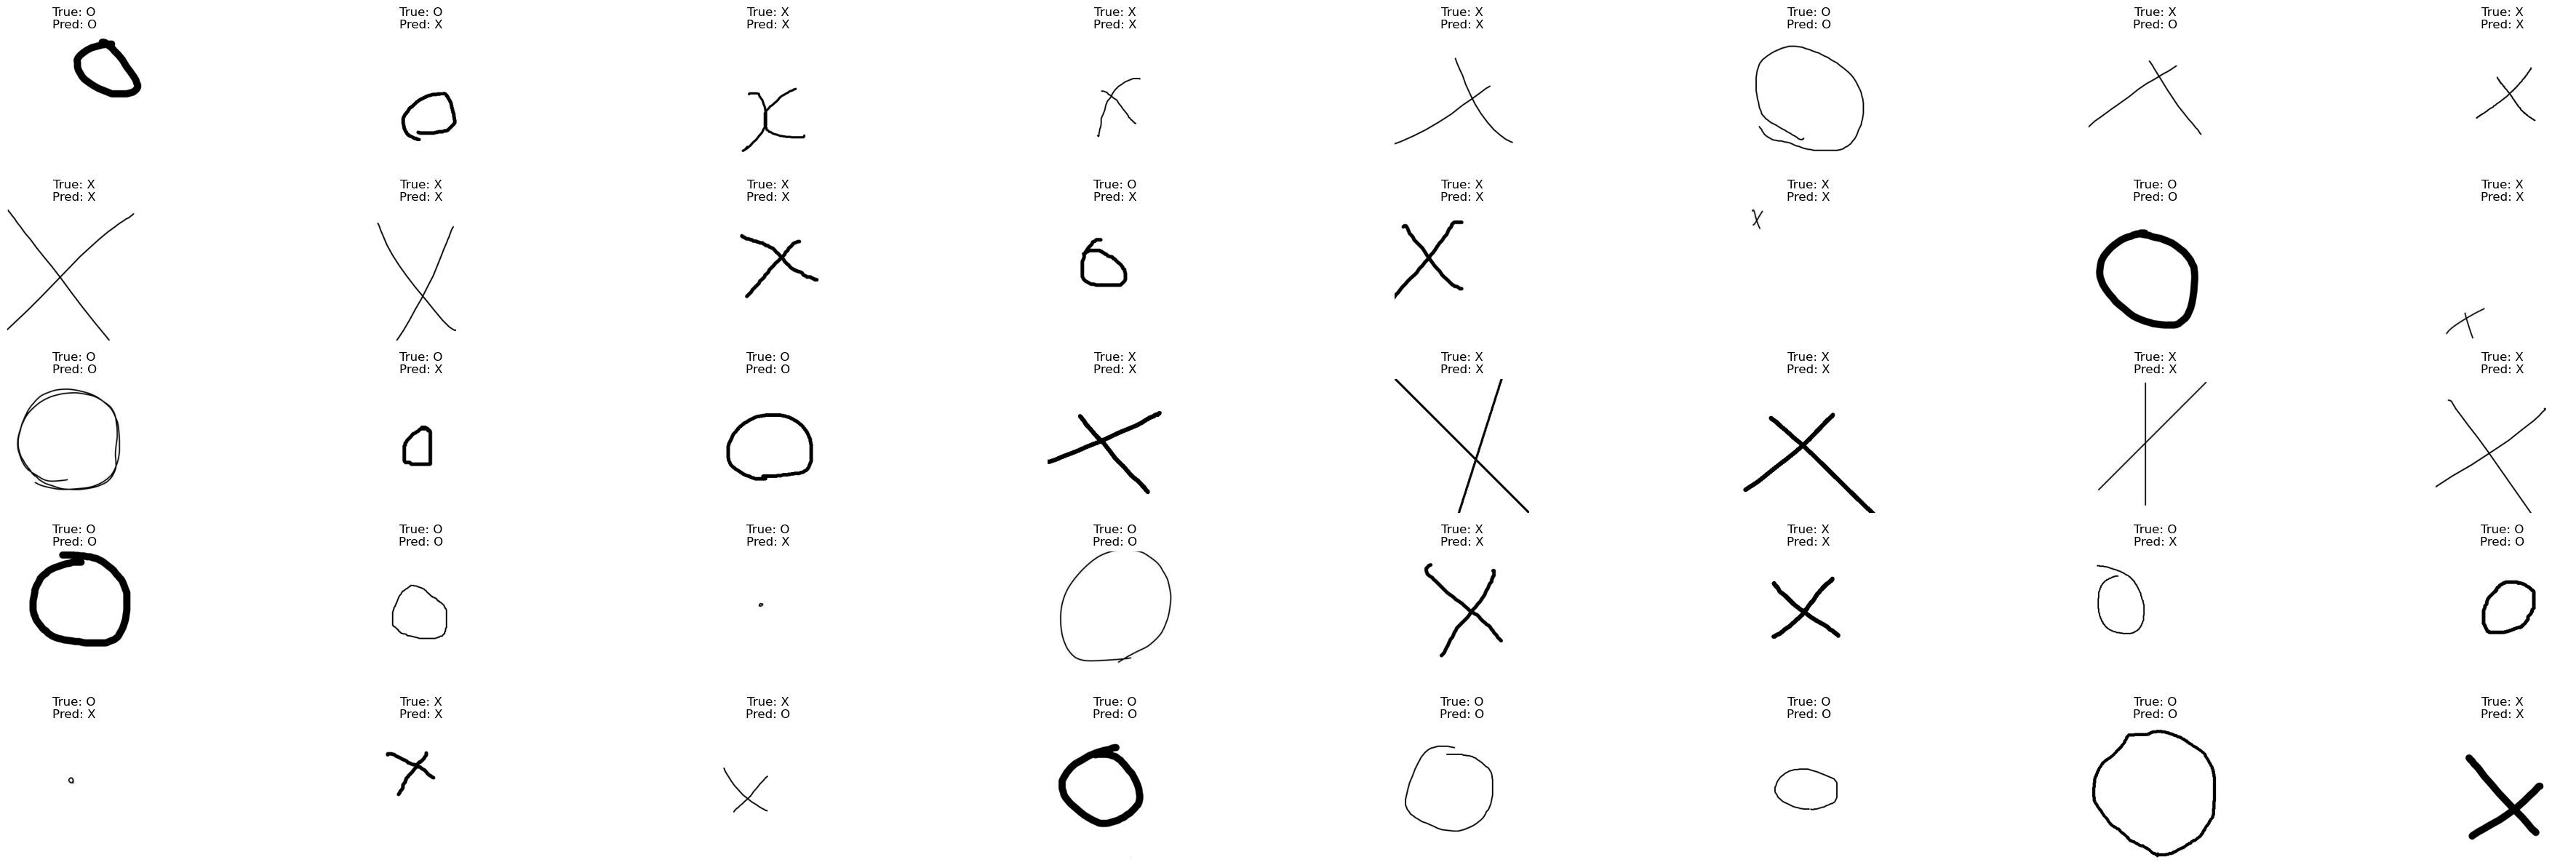

In [125]:
visualize_predictions(model, test_loader, num_images=40)